In [2]:
import numpy as np
import openslide
from openslide import deepzoom
import matplotlib.pyplot as plt


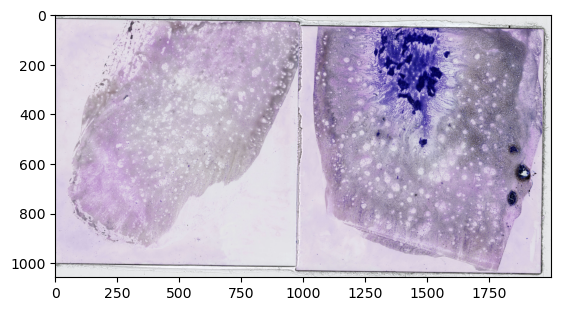

In [3]:
slidePath = "/home/exon_storage1/aml_slide/renameByUPN/"
slidePath = slidePath+"A1130.ndpi"
slide = openslide.open_slide(slidePath)
simg = np.array(slide.get_thumbnail((2000, 2000)))
plt.imshow(simg)


10
(196608, 103936)
((196608, 103936), (98304, 51968), (49152, 25984), (24576, 12992), (12288, 6496), (6144, 3248), (3072, 1624), (1536, 812), (768, 406), (384, 203))


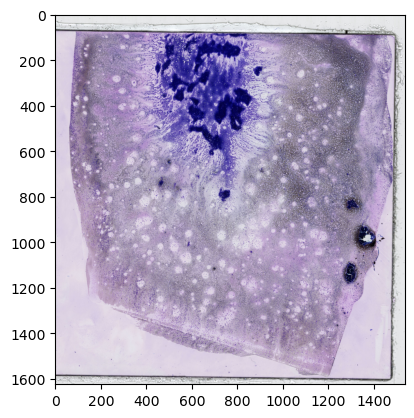

In [5]:
slide_level = 6 # 0 ~ 9
with openslide.OpenSlide(slidePath) as slide:
  print(slide.level_count) # 幾種分辨率
  print(slide.dimensions) #最高分辨率下的(width, height)
  print(slide.level_dimensions) #所有分辨率的(width,height)
  # print(slide.level_downsamples) # 每個分辨的倍數關係，即level_dimension[k] = dimensions / level_downsamples[k]
  dims = slide.level_dimensions
  level_dim = list(dims[slide_level])
  level_dim[0] = int(level_dim[0]/2)
  split_x =int(dims[0][0]/2)
  level6_img_RGB = slide.read_region((split_x,0),slide_level,level_dim).convert("RGB")
  #save image as new png file
  level6_img_RGB.save("split_slide.png")
  simg = np.array(level6_img_RGB)
  plt.imshow(simg)


<class 'PIL.Image.Image'>


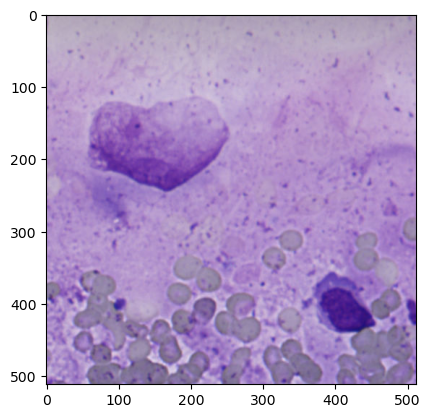

In [ ]:
with openslide.OpenSlide(slidePath) as slide:
  region = slide.read_region((512*237, 512*10), 0, (512, 512))
  print(type(region))
  plt.imshow(region)
  plt.show()